### Final Project for ACT4ED 2024 FALL MIT

In [9]:
import numpy as np
from math import sqrt

import torch

from torchfem import Truss
from torch import Tensor
from torchfem.materials import Material

from torchfem.materials import IsotropicElasticity1D
import matplotlib.pyplot as plt
import copy

import networkx as nx

class MyTruss(Truss):
        def __init__(self, nodes: Tensor, elements: Tensor, material: Material, number_of_panel: int):
            super().__init__(nodes, elements, material)
            self.number_of_panel = number_of_panel

        @torch.no_grad()
        def plot2d(
            self,
            u: float | Tensor = 0.0,
            element_property: Tensor | None = None,
            node_labels: bool = True,
            show_thickness: bool = False,
            thickness_max: float = 1.0, 
            thickness_threshold: float = 0.0,
            force_ratio: float | float = 1.0,
            default_color: str = "black",
            cmap: str = "viridis",
            title: str | None = None,
            axes: bool = False,
            vmin: float | None = None,
            vmax: float | None = None,
            ax: plt.Axes | None = None,
        ):
            import matplotlib.pyplot as plt
            # Set figure size
            if ax is None:
                _, ax = plt.subplots()

            # Line widths from areas
            if show_thickness:
                # a_max = torch.max(self.areas)
                linewidth = self.areas / thickness_max
            else:
                linewidth = 2.0 * torch.ones(self.n_elem)
                linewidth[self.areas < thickness_threshold] = 0.0

            # Line color from stress (if present)
            if element_property is not None:
                cm = plt.get_cmap(cmap)
                if vmin is None:
                    vmin = min(float(element_property.min()), 0.0)
                if vmax is None:
                    vmax = max(float(element_property.max()), 0.0)
                color = cm((element_property - vmin) / (vmax - vmin))
                sm = plt.cm.ScalarMappable(
                    cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax)
                )
                plt.colorbar(sm, ax=ax, shrink=0.5)
            else:
                color = self.n_elem * [default_color]

            # Nodes
            pos = self.nodes + u
            ax.scatter(pos[:, 0], pos[:, 1], color=default_color, marker="o", zorder=10)
            if node_labels:
                for i, node in enumerate(pos):
                    ax.annotate(
                        str(i), (node[0] + 0.01, node[1] + 0.1), color=default_color
                    )

            # Bounding box
            size = torch.linalg.norm(pos.max() - pos.min())

            # Bars
            for j, element in enumerate(self.elements):
                n1 = element[0]
                n2 = element[1]
                x = [pos[n1][0], pos[n2][0]]
                y = [pos[n1][1], pos[n2][1]]
                ax.plot(x, y, linewidth=linewidth[j], c=color[j])

            # Constraints
            for i, constraint in enumerate(self.constraints):
                if constraint[0]:
                    ax.plot(pos[i][0] - 0.8, pos[i][1], ">", markersize=10, color="gray")
                if constraint[1]:
                    ax.plot(pos[i][0], pos[i][1] - 0.8, "^", markersize=10, color="gray")

            # Forces
            for i, force in enumerate(self.forces):
                if torch.norm(force) > 0.0:
                    s = .4e-7 * size * force_ratio # scale
                    plt.arrow(
                        float(pos[i][0]),
                        float(pos[i][1]),
                        s * force[0],
                        s * force[1],
                        width=0.2,
                        facecolor="gray",
                        zorder = 100
                    )
                    
            # Adjustments
            nmin = pos.min(dim=0).values
            nmax = pos.max(dim=0).values


            ax.set(
                xlim=(float(nmin[0]) - 4, float(nmax[0]) + 4),
                ylim=(float(nmin[1]) - 12, float(nmax[1]) + 4),
            )

            if title:
                ax.set_title(title)

            ax.set_aspect("equal", adjustable="box")
            if not axes:
                ax.set_axis_off()




In [10]:
def Howe_bridge(number_of_panels, youngs):
    material = IsotropicElasticity1D(youngs)
    
    A = number_of_panels + 1  # less number of panels for better span
    B = 2                    # two-layer truss bridge

    # Nodes
    bridge_length=48
    bridge_height=8
    n1 = torch.linspace(0.0, bridge_length, A)
    n2 = torch.linspace(0.0, bridge_height, B)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

    # Elements
    connections=set()
    remove_nodes = np.array([A, 2*A-1])

    for i in range(A):
        for j in range(B):
            skip=[False]*4
            for node in remove_nodes:
                if i + j * A == node:
                    skip[0]=True
                if i + 1 + j * A == node:
                    skip[1]=True
                if i + A + j * A == node:
                    skip[2]=True
                if i + 1 + A + j * A == node:
                    skip[3]=True
            if i != A - 1:
                if skip[0] or skip[1]:
                    pass
                else:
                    connections.add((i + j * A, i + 1 + j * A))
            if j != B - 1:
                if skip[0] or skip[2]:
                    pass
                else:
                    connections.add((i + j * A, i + A + j * A))

            if i != A - 1 and j != B - 1:
                if i < (A - 1) / 2:
                    if skip[0] or skip[3]:
                        pass
                    else:
                        connections.add((i + j * A, i + 1 + A + j * A))
                else:
                    if skip[1] or skip[2]:
                        pass
                    else:
                        connections.add((i + 1 + j * A, i + A + j * A))

    connections = np.array(list(connections)).flatten()

    for node in remove_nodes:
        nodes=torch.cat([nodes[:node], nodes[node+1:]])
        remove_nodes -= 1
        connections[connections>node]-=1

    elements = torch.tensor(connections.reshape(-1,2))

    # Truss
    bridge = MyTruss(nodes.clone(), elements, material, A)
    return bridge

def Pratt_bridge(number_of_panels, youngs):
    material = IsotropicElasticity1D(youngs)
    
    A = number_of_panels + 1    # less number of panels for better span
    B = 2                      # two-layer truss bridge

    # Nodes
    bridge_length=48
    bridge_height=8
    n1 = torch.linspace(0.0, bridge_length, A)
    n2 = torch.linspace(0.0, bridge_height, B)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

    # Elements
    connections=set()
    remove_nodes = np.array([A, 2*A-1])

    for i in range(A):
        for j in range(B):
            skip=[False]*4
            for node in remove_nodes:
                if i + j * A == node:
                    skip[0]=True
                if i + 1 + j * A == node:
                    skip[1]=True
                if i + A + j * A == node:
                    skip[2]=True
                if i + 1 + A + j * A == node:
                    skip[3]=True
            if i != A - 1:
                if skip[0] or skip[1]:
                    pass
                else:
                    connections.add((i + j * A, i + 1 + j * A))
            if j != B - 1:
                if skip[0] or skip[2]:
                    pass
                else:
                    connections.add((i + j * A, i + A + j * A))

            if i != A - 1 and j != B - 1:
                if i == 0:
                    if skip[0] or skip[3]:
                        pass
                    else:
                        connections.add((i + j * A, i + 1 + A + j * A))
                if i == A - 2:
                    if skip[1] or skip[2]:
                        pass
                    else:
                        connections.add((i + 1 + j * A, i + A + j * A))


            if i != A - 1 and j != B - 1:
                if i < (A - 1) / 2:
                    if skip[1] or skip[2]:
                        pass
                    else:
                        connections.add((i + 1 + j * A, i + A + j * A))
                else:
                    if skip[0] or skip[3]:
                        pass
                    else:
                        connections.add((i + j * A, i + 1 + A + j * A))

    connections = np.array(list(connections)).flatten()

    for node in remove_nodes:
        nodes=torch.cat([nodes[:node], nodes[node+1:]])
        remove_nodes -= 1
        connections[connections>node]-=1

    elements = torch.tensor(connections.reshape(-1,2))

    # Truss
    bridge = MyTruss(nodes.clone(), elements, material, A)

    return bridge


def Warren_bridge(number_of_panels, youngs):
    material = IsotropicElasticity1D(youngs)
    
    A = number_of_panels + 1   # less number of panels for better span
    B = 2                     # two-layer truss bridge

    # Nodes
    bridge_length=48
    bridge_height=8
    n1 = torch.linspace(0.0, bridge_length, A)
    n2 = torch.linspace(0.0, bridge_height, B)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)
    
    nodes[A:,0]-=(bridge_length/(A-1))/2
    # Elements
    connections=set()
    remove_nodes = np.array([A])

    for i in range(A):
        for j in range(B):
            skip=[False]*4
            for node in remove_nodes:
                if i + j * A == node:
                    skip[0]=True
                if i + 1 + j * A == node:
                    skip[1]=True
                if i + A + j * A == node:
                    skip[2]=True
                if i + 1 + A + j * A == node:
                    skip[3]=True
                    
            if i != A - 1:
                if skip[0] or skip[1]:
                    pass
                else:
                    connections.add((i + j * A, i + 1 + j * A))
                    
            if j != B - 1:
                if skip[0] or skip[2]:
                    pass
                else:
                    connections.add((i + j * A, i + A + j * A))

            if i != A - 1 and j != B - 1:
                
                if skip[0] or skip[3]:
                    pass
                else:
                    connections.add((i + j * A, i + 1 + A + j * A))
                # else:
                #     if skip[1] or skip[2]:
                #         pass
                #     else:
                #         connections.add((i + 1 + j * A, i + A + j * A))

    connections = np.array(list(connections)).flatten()

    for node in remove_nodes:
        nodes=torch.cat([nodes[:node], nodes[node+1:]])
        remove_nodes -= 1
        connections[connections>node]-=1

    elements = torch.tensor(connections.reshape(-1,2))

    # Truss
    bridge = MyTruss(nodes.clone(), elements, material, A)

    return bridge


In [11]:
def apply_load(bridge, load, number_of_panels):
    A = number_of_panels + 1
    bridge_length = 48
    # Forces at bottom edge
    bridge.forces[1 : A - 1, 1] = -load*bridge_length/(A-1)
    bridge.forces[  0, 1] = -load*bridge_length/(A-1)/2
    bridge.forces[A-1, 1] = -load*bridge_length/(A-1)/2

    # print(f'Forces: {bridge.forces}')
    # Constraints by the supports
    bridge.constraints[0, 0] = True
    bridge.constraints[0, 1] = True
    bridge.constraints[A - 1, 1] = True
    return bridge


67.1560084864103 MPa, 7.04662492375896 m^3


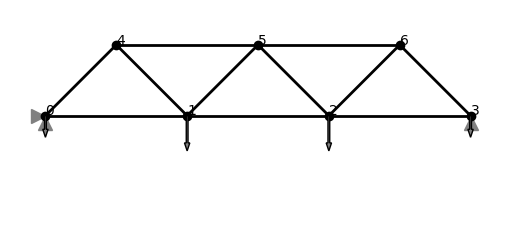

In [ ]:
def dp_bridge(sigma_yield, bridge):
    
    torch.set_default_dtype(torch.double)

    def compute_lengths(truss):
        start_nodes = truss.nodes[truss.elements[:, 0]]
        end_nodes = truss.nodes[truss.elements[:, 1]]
        dx = end_nodes - start_nodes
        return torch.linalg.norm(dx, dim=-1)

    area = 5
    
    while True:
        bridge_copy = copy.deepcopy(bridge)

        bridge_copy.areas = bridge_copy.areas*area
        _, _, sigma, _, _ = bridge_copy.solve()

        if torch.max(sigma)*1.5 < sigma_yield:
            area*=0.99
        
        else:
            break
      
    lengths = compute_lengths(bridge)
    volume = torch.inner(bridge_copy.areas, lengths)
    print(f"{torch.max(sigma)/1e6} MPa, {volume} m^3")
    return bridge_copy, sigma, float(volume)

# Example usage
try:
    number_of_panels = 4
    bridge = Warren_bridge(3, 100e9)
    bridge = apply_load(bridge, 100e3, 3)
    bridge,_,_ = dp_bridge(100e6, bridge)
    bridge.plot()
except:
    pass


In [19]:
# transport supplier dp

def dp_truck(file_path):
    haulers_graph = nx.read_graphml(f"knowledge_graph/{file_path}")
    edges = list(haulers_graph.out_edges)

    truck_options = set()
    truck_cost_load = {}

    data_truck = f'''
F:
- "kg"
R:
- "USD"
implementations:
'''
    
    data_truck_grid = f'''
F:
- "kg"
R:
- "USD"
implementations:
'''

    for edge in edges:
        if 'trucks' in edge[0].lower():
            truck = edge[0].split()[0]
            truck_options.add(truck)
            if 'load' in edge[1].lower():
                truck_cost_load[truck] = float(edge[1].replace('/load','').replace('$',''))
            if 'mile' in edge[1].lower():
                truck_cost_load[truck] += float(edge[1].replace('/mile','').replace('$',''))*10 # assuming 10 miles from the warehouse to the construction site

    # # Define truck capacities in tons
    truck_capacities = {
        "Small": 5,
        "Medium": 20,
        "Large": 40  # Assuming max capacity for large trucks
    }

    for truck_type, capacity in truck_capacities.items():
        data_truck += f'''
  {truck_type}:
    f_max:
    - "{capacity*1000} kg"
    r_min:
    - "{truck_cost_load[truck_type]} USD"'''

    
    with open(f"building_bridge.mcdplib/truck_catalogues/truck_catalogue.yaml", 'w', encoding="UTF-8") as file_stream:
        file_stream.write(data_truck)

    # Initialize the result dictionary
    truck_usage = {truck: 0 for truck in truck_capacities}
    
    # Calculate the number of trucks required

    for i in range(0, 10):
        for j in range(0, 10):
            for k in range(0, 10):

                truck_usage['Small'] = k
                truck_usage['Medium'] = j
                truck_usage['Large'] = i
                total_capacity = np.sum([ truck_capacities[truck_type]*truck_usage[truck_type] for truck_type, _ in truck_capacities.items() ])
                if total_capacity == 0:
                    continue

                total_cost = np.sum([ truck_cost_load[truck_type]*truck_usage[truck_type] for truck_type, _ in truck_capacities.items() ])
                data_truck_grid += f'''
  s{k}_m{j}_l{i}:
    f_max:
    - "{total_capacity*1000} kg"
    r_min:
    - "{total_cost} USD"'''

    with open(f"building_bridge.mcdplib/truck_catalogues/truck_grid_catalogue.yaml", 'w', encoding="UTF-8") as file_stream:
        file_stream.write(data_truck_grid)

# Example usage
file_path = "haulers.graphml" 
truck_plan = dp_truck(file_path)


In [14]:
# reading materials supplier knowledge graph

def collect_materials(file_path):
    material_graph=nx.read_graphml(f"knowledge_graph/{file_path}")
    edges = list(material_graph.out_edges)

    material_categories = set()
    materials = set()
    properties = set()
    materials_dict = {}

    for edge in edges:
        if 'Engineering Material' in edge[0]:
            material_categories.add(edge[1])
    
    for cat in material_categories:
        for edge in edges:
            if cat in edge[1] and 'Engineering Material' not in edge[0]:
                if edge[0] == 'Kevlar' or  edge[0] == 'Graphene':
                    continue
                materials.add(edge[0])

    for m in materials:
        materials_dict[m]={}
        for edge in edges:
            if m == edge[0] and 'Category' not in edge[1]:
                p = edge[1].split(':')[0].replace("'s", "s")
                value = float(edge[1].split(':')[-1])
                properties.add(p)
                materials_dict[m][p] = value
    return materials, materials_dict

In [ ]:
import subprocess
from decimal import Decimal
import yaml

def main(load):
    data_FEA='''
F:
- "N"
R:
- "kg"
- "USD"
implementations:
'''

    types_of_bridge = [Howe_bridge, Pratt_bridge, Warren_bridge]
    names_of_bridge = ['Howe', 'Pratt', 'Warren']
    number_of_panels = [4, 6, 8]
    
    materials, materials_dict = collect_materials('materials_properties.graphml')

    for i, type_of_bridge in enumerate(types_of_bridge):
        for number_of_panel in number_of_panels:
            for m in materials:
                youngs  = materials_dict[m]['Youngs Modulus (GPa)']*1e9
                s_yield = materials_dict[m]['Yield Strength (MPa)']*1e6
                density = materials_dict[m]['Density (g/cm³)']*1000 # to [kg/m^3]
                price = materials_dict[m]['Price per Unit ($/kg)']

                bridge = type_of_bridge(number_of_panel, youngs)
                bridge = apply_load(bridge, load, number_of_panel)
                try:
                    print(f'{names_of_bridge[i][0]}_{number_of_panel}_{m.replace(" ", "-")}')
                    bridge, sigma, volume = dp_bridge(s_yield, bridge)
                    bridge.plot(element_property = sigma, axes=True, cmap='seismic',
                                # vmin=-s_yield, vmax=s_yield,
                                show_thickness=True, thickness_max = 0.1, force_ratio = number_of_panels[0]/(number_of_panel-1))
                    plt.xlabel('distance [m]')
                    plt.ylabel('distance [m]')
                    plt.savefig(f'figure/{names_of_bridge[i][0]}_{number_of_panel}_{m.replace(" ", "-")}.png')
                    # plt.show()
                    plt.close()
                    mass_bridge = volume*density
                    cost_bridge = price*mass_bridge
                    
                    data_FEA += f'''
  {names_of_bridge[i][0]}_{number_of_panel}_{m.replace(" ", "-")}:
    f_max:
    - "{load} N"
    r_min:
    - "{mass_bridge} kg"
    - "{cost_bridge} USD"'''
                    
                except:
                    bridge.plot(axes=True, cmap='seismic',
                                vmin=-s_yield, vmax=s_yield, show_thickness=True, thickness_max = 0.1)
                    print('err')
                    return
        # write the implementation to the actual catalogue file
                   
        with open("building_bridge.mcdplib/bridge_catalogues/bridge_catalogue.yaml", 'w', encoding="UTF-8") as file_stream:
            file_stream.write(data_FEA)

    # start the docker container
    container_id = subprocess.check_output("docker run --platform linux/amd64 -it --rm -v .:/work -w /work -d zupermind/mcdp:2024 bash -l", shell=True).decode().strip()
    print(f"Container ID: {container_id}")
    query = "project"

    subprocess.run(f"docker exec {container_id} mcdp-solve-query {query}", shell=True, check=True)

    
    # read the output file and parse the results. Pay attention to which output file you are reading!
    with open("out-query/output.yaml", 'r', encoding="UTF-8") as file_stream:
        data = yaml.safe_load(file_stream)
        optimistic_antichain = eval(data['optimistic']['minimals'])
        print("Optimistic antichain:")
        print(optimistic_antichain)
        for resource_element in optimistic_antichain:
            print("Resource element:")
            print(resource_element)
            for single_resource in resource_element:
                print("Single resources in the resource antichain:")
                print(single_resource)
                if isinstance(single_resource, tuple):
                    print("The resource element is a Tuple (element in the product of posets)")
                    print(single_resource[0])
                    print(single_resource[1])

    # Do as many queries as you want!
    # if you want to supress the output when solving the queries, you can use the following command
    # By looking into "subprocess" of Python more carefully, you may find better solutions to supress the output.
    # print("Solving the query again with suppressing the output.")
    # subprocess.run(f"docker exec {container_id} mcdp-solve-query {query}", shell=True, check=True, capture_output=True)

    # stop the docker container
    # subprocess.run(f"docker stop {container_id}", shell=True, check=True)
    return
if __name__ == '__main__':
    load = 200e3
    main(load)
  


H_4_Stainless-Steel
167.076530229717 MPa, 6.623069711897987 m^3
H_4_Aluminum-Alloy
184.74108990726126 MPa, 5.989785528974267 m^3
H_4_Concrete
2.00632400963495 MPa, 551.5357946271047 m^3
H_4_Glass
33.46159073207311 MPa, 33.06954280188489 m^3
H_4_Wood-(Oak)
26.82383470546604 MPa, 41.25284542958941 m^3
H_4_Copper
47.092307019035495 MPa, 23.497670362298507 m^3
H_4_Polyethylene
13.407545869687308 MPa, 82.53259154870696 m^3
H_4_Polycarbonate
40.09711077014353 MPa, 27.596988553035633 m^3
H_4_Carbon-Fiber
801.3552568738285 MPa, 1.3808601084745473 m^3
H_4_Titanium-Alloy
558.0743932404507 MPa, 1.9828172020368684 m^3
H_4_Rubber
3.34970179441437 MPa, 330.34567697299127 m^3
H_6_Stainless-Steel
167.07653022971832 MPa, 8.0966022295065 m^3
H_6_Aluminum-Alloy
184.74108990726077 MPa, 7.3224219248420015 m^3
H_6_Concrete
2.006324009634948 MPa, 674.2441403581041 m^3
H_6_Glass
33.46159073207335 MPa, 40.427014303881116 m^3
H_6_Wood-(Oak)
26.8238347054661 MPa, 50.43097759920499 m^3
H_6_Copper
47.0923070190352